In [3]:
!pip install datasets
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AdamW
)
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

In [8]:
# Add seed setting after imports
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed()

# Mount Google Drive (safely)
try:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    FILE_PATH = "/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent"
    print("\n" + "="*50)
    print("✓ Google Drive mounted successfully")
    print("✓ File directory:", FILE_PATH)
    print("="*50 + "\n")

except Exception as e:
    print("✗ Error mounting Google Drive:", str(e))
    raise

# Configuration
CONFIG = {
    'MODEL_NAME': 'distilroberta-base',  # Changed from roberta-base
    'MAX_LENGTH': 256,
    'BATCH_SIZE': 64,                    # Can be larger due to smaller model
    'CACHE_SIZE': 50000,
    'NUM_EPOCHS': 2,
    'LEARNING_RATE': 2e-5,
    'WARMUP_RATIO': 0.1,
    'WEIGHT_DECAY': 0.01,
    'GRAD_ACCUMULATION': 2,              # Reduced from 4 due to larger batch
    'ADAM_EPSILON': 1e-8,
    'MAX_GRAD_NORM': 1.0,
    'DROPOUT': 0.1,
    'LABEL_SMOOTHING': 0.1,
    'PATIENCE': 3,
    'MIN_DELTA': 0.001
}

# Create datasets
class StreamingDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.data = df
        self.tokenizer = tokenizer
        self.cache = {}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['processed_text'],
            max_length=CONFIG['MAX_LENGTH'],
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
        label = sentiment_map[row['sentiment']]

        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        if len(self.cache) < CONFIG['CACHE_SIZE']:
            self.cache[idx] = item

        return item


✓ Google Drive mounted successfully
✓ File directory: /content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent



In [17]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create checkpoint directory
checkpoint_dir = f"{FILE_PATH}/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['MODEL_NAME'])
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['MODEL_NAME'],
    num_labels=3,
    hidden_dropout_prob=CONFIG['DROPOUT'],
    attention_probs_dropout_prob=CONFIG['DROPOUT']
).to(device)

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Load full dataset
print("Loading full dataset...")
train_df = pd.read_parquet(f"{FILE_PATH}/train_processed.parquet")
val_df = pd.read_parquet(f"{FILE_PATH}/val_processed.parquet")
test_df = pd.read_parquet(f"{FILE_PATH}/test_processed.parquet")

# Print original distributions
print("\nOriginal class distributions:")
print("\nTrain set:")
print(train_df['sentiment'].value_counts())
print("\nValidation set:")
print(val_df['sentiment'].value_counts())
print("\nTest set:")
print(test_df['sentiment'].value_counts())

# Set sampling parameters
samples_per_class = 200_000
val_size = 50_000
test_size = 50_000
random_state = 42

# Create balanced datasets
balanced_train = []
balanced_val = []
balanced_test = []

for sentiment in ['Negative', 'Neutral', 'Positive']:
    print(f"\nProcessing {sentiment} class...")

    # Get all samples for this class
    class_samples = train_df[train_df['sentiment'] == sentiment].copy()
    total_samples = len(class_samples)

    print(f"Total {sentiment} samples available: {total_samples:,}")

    # Shuffle the samples
    class_samples = shuffle(class_samples, random_state=random_state)

    # Split the data
    train_samples = class_samples[:samples_per_class]
    val_samples = class_samples[samples_per_class:samples_per_class+val_size//3]
    test_samples = class_samples[samples_per_class+val_size//3:samples_per_class+val_size//3+test_size//3]

    # Append to respective lists
    balanced_train.append(train_samples)
    balanced_val.append(val_samples)
    balanced_test.append(test_samples)

    print(f"Selected {len(train_samples):,} for training")
    print(f"Selected {len(val_samples):,} for validation")
    print(f"Selected {len(test_samples):,} for testing")

# Combine and shuffle the final datasets
train_df = shuffle(pd.concat(balanced_train, ignore_index=True), random_state=random_state)
val_df = shuffle(pd.concat(balanced_val, ignore_index=True), random_state=random_state)
test_df = shuffle(pd.concat(balanced_test, ignore_index=True), random_state=random_state)

# Print final distributions
print("\nFinal class distributions:")
print("\nTraining set:")
print(train_df['sentiment'].value_counts())
print("\nValidation set:")
print(val_df['sentiment'].value_counts())
print("\nTest set:")
print(test_df['sentiment'].value_counts())

# Save the balanced datasets
print("\nSaving balanced datasets...")
train_df.to_parquet(f"{FILE_PATH}/balanced_train.parquet")
val_df.to_parquet(f"{FILE_PATH}/balanced_val.parquet")
test_df.to_parquet(f"{FILE_PATH}/balanced_test.parquet")

# Create datasets and dataloaders with the balanced data
train_dataset = StreamingDataset(train_df, tokenizer)
val_dataset = StreamingDataset(val_df, tokenizer)
test_dataset = StreamingDataset(test_df, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    num_workers=0,
    pin_memory=True
)

print("\nDatasets created successfully!")
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

# Optimizer with weight decay
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters()
                  if not any(nd in n for nd in no_decay)],
        'weight_decay': CONFIG['WEIGHT_DECAY']
    },
    {
        'params': [p for n, p in model.named_parameters()
                  if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=CONFIG['LEARNING_RATE'],
    eps=CONFIG['ADAM_EPSILON']
)

# Learning rate scheduler
num_training_steps = len(train_loader) * CONFIG['NUM_EPOCHS']
warmup_steps = int(num_training_steps * CONFIG['WARMUP_RATIO'])
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

# Training loop
best_val_f1 = 0
early_stopping_counter = 0
best_val_loss = float('inf')

print("Starting training...")

# Calculate class weights
print("\nCalculating class weights...")
# Calculate weights from DataFrame directly
train_labels_array = train_df['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2}).values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_array),
    y=train_labels_array
)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=CONFIG['LABEL_SMOOTHING']
)
print("✓ Class weights calculated:", class_weights.cpu().numpy())

for epoch in range(CONFIG['NUM_EPOCHS']):
    # Training
    model.train()
    total_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']}")

    optimizer.zero_grad()
    for i, batch in enumerate(progress):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Calculate loss
        loss = outputs.loss / CONFIG['GRAD_ACCUMULATION']
        loss.backward()

        if (i + 1) % CONFIG['GRAD_ACCUMULATION'] == 0:
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                CONFIG['MAX_GRAD_NORM']
            )
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        progress.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = precision_recall_fscore_support(
        val_labels, val_preds, average='weighted'
    )[2]

    # Print metrics
    print(f"\nEpoch {epoch+1}/{CONFIG['NUM_EPOCHS']}:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Val F1: {val_f1:.4f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_f1': val_f1,
        'config': CONFIG
    }
    torch.save(checkpoint, f"{checkpoint_dir}/checkpoint.pt")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pt")
        print("✓ Saved new best model!")

    # Early stopping
    if val_loss < best_val_loss - CONFIG['MIN_DELTA']:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= CONFIG['PATIENCE']:
            print("\nEarly stopping triggered!")
            break


✓ Google Drive mounted successfully
✓ File directory: /content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent

Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading full dataset...

Original class distributions:

Train set:
sentiment
Positive    9101980
Negative    1960371
Neutral      834402
Name: count, dtype: int64

Validation set:
sentiment
Positive    1208419
Negative     252731
Neutral      112356
Name: count, dtype: int64

Test set:
sentiment
Positive    1157797
Negative     237929
Neutral      112293
Name: count, dtype: int64

Processing Negative class...
Total Negative samples available: 1,960,371
Selected 200,000 for training
Selected 16,666 for validation
Selected 16,666 for testing

Processing Neutral class...
Total Neutral samples available: 834,402
Selected 200,000 for training
Selected 16,666 for validation
Selected 16,666 for testing

Processing Positive class...
Total Positive samples available: 9,101,980
Selected 200,000 for training
Selected 16,666 for validation
Selected 16,666 for testing

Final class distributions:

Training set:
sentiment
Negative    200000
Neutral     200000
Positive    200000
Name: count, dtype: in

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2:   0%|          | 0/9375 [00:00<?, ?it/s]

Validating:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1/2:
Train Loss: 0.2823
Val Loss: 0.4904
Val Accuracy: 0.7918
Val F1: 0.7924
✓ Saved new best model!


Epoch 2/2:   0%|          | 0/9375 [00:00<?, ?it/s]

Validating:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2/2:
Train Loss: 0.2390
Val Loss: 0.4797
Val Accuracy: 0.7960
Val F1: 0.7960
✓ Saved new best model!


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-a1ff9a0efd85>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

Evaluating model...


  0%|          | 0/782 [00:00<?, ?it/s]


Test Metrics:
Loss: 0.4849
Accuracy: 0.7967
Precision: 0.7966
Recall: 0.7967
F1 Score: 0.7966


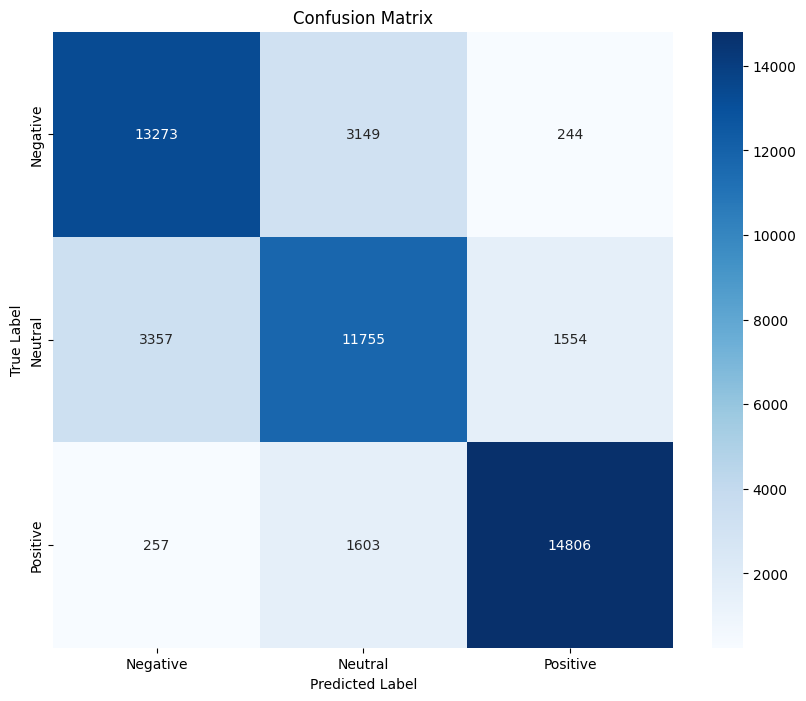


Per-class Metrics:

Negative:
Precision: 0.7860
Recall: 0.7964
F1: 0.7912
Support: 16666

Neutral:
Precision: 0.7121
Recall: 0.7053
F1: 0.7087
Support: 16666

Positive:
Precision: 0.8917
Recall: 0.8884
F1: 0.8901
Support: 16666


In [9]:
# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModelForSequenceClassification.from_pretrained(
    'distilroberta-base',
    num_labels=3
).to(device)

# Load trained weights
checkpoint_dir = "/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent/checkpoints"
checkpoint = torch.load(f"{checkpoint_dir}/best_model.pt")
model.load_state_dict(checkpoint)
model.eval()

# Define FILE_PATH
FILE_PATH = "/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent"


# Load balanced test data
test_df = pd.read_parquet(f"{FILE_PATH}/balanced_test.parquet")
test_dataset = StreamingDataset(test_df, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=0,
    pin_memory=True
)

# Evaluation
all_preds = []
all_labels = []
test_loss = 0

print("Evaluating model...")
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        test_loss += outputs.loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_loader)
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average='weighted'
)

# Print metrics
print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class metrics
print("\nPer-class Metrics:")
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"\n{label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1: {f1[i]:.4f}")
    print(f"Support: {support[i]}")


Test Metrics:
Loss: 0.0008
Accuracy: 0.9104
Precision: 0.9069
Recall: 0.9104
F1 Score: 0.9083


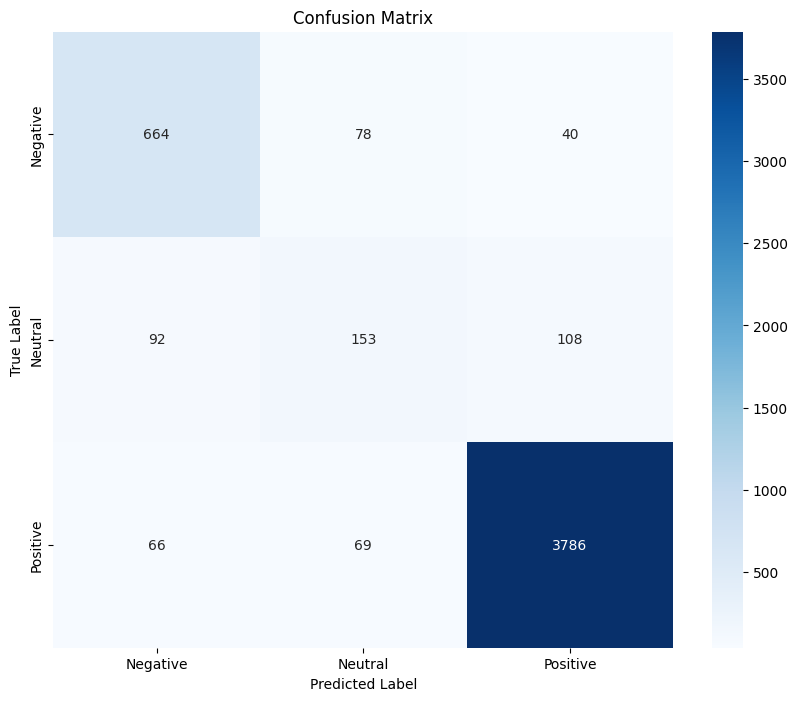


Per-class Metrics:

Negative:
Precision: 0.8078
Recall: 0.8491
F1: 0.8279
Support: 782

Neutral:
Precision: 0.5100
Recall: 0.4334
F1: 0.4686
Support: 353

Positive:
Precision: 0.9624
Recall: 0.9656
F1: 0.9640
Support: 3921


In [16]:

"""# Calculate metrics
test_loss = test_loss / len(test_loader)
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average='weighted'
)

# Print metrics
print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class metrics
print("\nPer-class Metrics:")
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"\n{label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1: {f1[i]:.4f}")
    print(f"Support: {support[i]}")"""